<a href="https://colab.research.google.com/github/enVives/TFG/blob/main/EvaluacioArquitectures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import cv2
import random
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import wandb
import pylab as pl
import json

from glob import glob
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
from torchvision import transforms,models
from torch import nn
from torch.utils.data import Dataset
from google.colab import files
from IPython.display import clear_output,display
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage import io
from google.colab import drive


WEIGHTSANDBIASES = True
DOWNLOAD = True
SEGMENTATION = True
CLAHE = False

# ORIGEN = '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000/'



drive.mount('/content/drive')


if DOWNLOAD:
  !rm -rf /content/sample_data/*

  !kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

  !unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

  !kaggle datasets download -d "tschandl/ham10000-lesion-segmentations"

  !unzip -o ham10000-lesion-segmentations.zip -d /content/sample_data/

#471be466c8949671a46c67e7aad0d5a0ac8c9dad

if WEIGHTSANDBIASES:
  wandb.login()

#torch.cuda.default_stream(torch.device('cuda'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029321_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029322_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029323_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029324_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029325_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029326_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029327_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029328_segmentation.png  
  inflating: /content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0029329_segmentation.png  
  in

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pjvivesmorey (pjvivesmorey-uib) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


!rm -rf /content/sample_data/*

!kaggle datasets download -d "kmader/skin-cancer-mnist-ham10000"

!unzip -o skin-cancer-mnist-ham10000.zip -d /content/sample_data/

In [2]:

metadates = pd.read_csv('/content/sample_data/HAM10000_metadata.csv')
metadates = metadates.sort_values(by='image_id')
metadates.head()
print(metadates['dx'].value_counts())
print()
print(metadates['dx'].value_counts() / sum(metadates['dx'].value_counts()))

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

dx
nv       0.669496
mel      0.111133
bkl      0.109735
bcc      0.051323
akiec    0.032651
vasc     0.014179
df       0.011483
Name: count, dtype: float64


nv: melanocytic nevi

vasc: vascular lesions

mel:melanoma

df: dermatofibroma

bkl: benign keratosis-like lesions

bcc: basal cell carcinoma

akiec: Actinic keratoses and intraepithelial carcinoma / Bowen's disease

In [3]:
class Formes(Dataset):
  #Classe on gestionarem les imatges dels fitxers
  dict_illnesses = {0 : 'nv', 1 : 'mel', 2 : 'bkl', 3 : 'bcc', 4 : 'akiec', 5 : 'vasc', 6 : 'df'}

  def __init__(self, images, labels, transform):
        super().__init__()
        self.paths = images
        self.labels = labels
        self.len = len(self.paths)
        self.transform = transform
        #Per defecte pens que el color pot extreure característiques importants, per tant en primer lloc
        #entrenarem les imatges de color
        self.greyscale = False

  def __len__(self):
        return self.len

  def __setmasks__(self,masks):
      self.masks = masks

  def __getmask__(self,i):
      return self.masks[i]

  def __lenmasks__(self):
    return len(self.masks)

  def __addlabel__(self,label):
    self.labels = np.append(self.labels,label)

  def __addPath__(self,path):
    self.paths = np.append(self.paths,path)

  def __getdist__(self):
    return pd.Series(self.labels).value_counts()

  def __getlabels__(self):
    classes = [[],[],[],[],[],[],[]]
    for i in range(len(self.labels)):
      classes[self.labels[i]].append(i) #afegim l'index
    return classes

  def __redistribute__(self,percentages):
    #percentages: [15,15,10,10,5,5] percentatges que volem pujar de la resta de classes llevat de nv
    threshold = 0.005  #percentatge de marge que deixam a la redistribució
    Ntarget = self.len
    classes = self.__getlabels__() #indexos de cada clase
    afegir = np.array([0,0,0,0,0,0],dtype=np.int64) # de nv mai haurem d'afegir

    nmel = len(classes[1]) #nombre inicial de cada clase
    nbkl = len(classes[2])
    nbcc = len(classes[3])
    nakiec = len(classes[4])
    nvasc = len(classes[5])
    ndf = len(classes[6])

    while True:

      suma_actual = afegir.sum()

      operacio = percentages[0]*Ntarget - nmel
      afegir[0] +=  operacio if operacio > 0 else 0
      nmel += operacio if operacio > 0 else 0

      operacio = percentages[1]*Ntarget - nbkl
      afegir[1] += operacio if operacio > 0 else 0
      nbkl += operacio if operacio > 0 else 0

      operacio = percentages[2]*Ntarget - nbcc
      afegir[2] += operacio if operacio > 0 else 0
      nbcc += operacio if operacio > 0 else 0

      operacio = percentages[3]*Ntarget - nakiec
      afegir[3] += operacio if operacio > 0 else 0
      nakiec += operacio if operacio > 0 else 0

      operacio = percentages[4]*Ntarget - nvasc
      afegir[4] += operacio if operacio > 0 else 0
      nvasc += operacio if operacio > 0 else 0

      operacio = percentages[5]*Ntarget - ndf
      afegir[5] += operacio if operacio > 0 else 0
      ndf += operacio if operacio > 0 else 0

      if (afegir.sum()-suma_actual) < Ntarget*threshold:
        break

      Ntarget += (afegir.sum()-suma_actual)

    #Quedaria afegir a les imatges les còpies
    for i in range(len(afegir)):
      for j in range(afegir[i]):

          self.__addPath__(self.paths[classes[i+1][random.randint(0, len(classes[i+1]) - 1)]])
          self.__addlabel__(i+1)

    self.len = len(self.labels)

  def __setgreyscale__(self,mode):
    self.greyscale = mode

  def __getpath__(self,index):
    return self.paths[index]

  def __getitem__(self, index):
      path = self.paths[index]
      label = self.labels[index]

      image = cv2.imread(path, cv2.IMREAD_GRAYSCALE if self.greyscale else cv2.IMREAD_COLOR)

      if SEGMENTATION:
        mask = cv2.imread(self.masks[index], cv2.IMREAD_GRAYSCALE)
        _, mask_binaria = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        image = cv2.bitwise_and(image, image, mask=mask_binaria)

        non_black_pixels = np.where(image > 0)

        x_min, x_max = np.min(non_black_pixels[1]), np.max(non_black_pixels[1])
        y_min, y_max = np.min(non_black_pixels[0]), np.max(non_black_pixels[0])

        marge = 10
        if ((x_min - marge) >= 0):
            x_min = x_min - marge
        if ((x_max + marge) <= 224):
            x_max = x_max + marge

        cropped_image = image[y_min:y_max, x_min:x_max]
        image = cv2.resize(cropped_image, (224, 224), interpolation=cv2.INTER_CUBIC)

      #preprocessament
      if CLAHE:
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
        l_clahe = clahe.apply(l)
        lab_clahe = cv2.merge((l_clahe, a, b))
        image = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)




      if self.greyscale:
        image = Image.fromarray(image, mode="L")
      else:
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      image = self.transform(image)

      return image, label

In [4]:
def calcula_mitjana_desviacio(img_files_path):
  mitjana = np.array([0.0, 0.0, 0.0], dtype=np.float64)
  desviacio = np.array([0.0, 0.0, 0.0], dtype=np.float64)

  x,y = 256,256
  pixels_totals_canal = len(img_files_path) * x * y

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)

    mitjana += np.array([canal_r.sum(), canal_g.sum(), canal_b.sum()])
    #desviacio += np.array([(canal_r**2).sum(), (canal_g**2).sum(), (canal_b**2).sum()])

  mitjana = mitjana / pixels_totals_canal

  for i in range(len(img_files_path)):
    imatge = cv2.imread(img_files_path[i])
    imatge = cv2.resize(imatge,(x,y))

    canal_b, canal_g, canal_r = cv2.split(imatge)
    desviacio += np.array([((canal_r-mitjana[0])**2).sum(), ((canal_g-mitjana[1])**2).sum(), ((canal_b-mitjana[2])**2).sum()])


  desviacio = np.sqrt(desviacio / pixels_totals_canal)

  return mitjana,desviacio

In [5]:
def load_sets(transformation_training,transformation_default,training_dist,valitation_dist,testing_dist,distribution):

  illnes_dictionary = {
      'nv': 'Melanocytic nevi',
      'mel': 'Melanoma',
      'bkl': 'Benign keratosis-like lesions ',
      'bcc': 'Basal cell carcinoma',
      'akiec': 'Actinic keratoses and intraepithelial carcinoma / Bowens disease',
      'vasc': 'Vascular lesions',
      'df': 'Dermatofibroma'
  }

  img_files_1 = sorted(glob('/content/sample_data/HAM10000_images_part_1/*'))
  img_files_2 = sorted(glob('/content/sample_data/HAM10000_images_part_2/*'))
  img_files = img_files_1 + img_files_2

  img_files = np.array(img_files)

  mask_files = sorted(glob('/content/sample_data/HAM10000_segmentations_lesion_tschandl/*'))

  imgid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in img_files}

  mask_path_dict = {os.path.splitext(os.path.basename(x))[0].replace('_segmentation', ''): x for x in mask_files}

  #print(mask_path_dict)

  #{'ISIC_0024306_segmentation': '/content/sample_data/HAM10000_segmentations_lesion_tschandl/ISIC_0024306_segmentation.png'

  metadates['path'] = metadates['image_id'].map(imgid_path_dict.get)
  metadates['mask_path'] = metadates['image_id'].map(mask_path_dict.get)

  metadates['illness'] = metadates['dx'].map(illnes_dictionary.get)
  metadates['illness_code'] = metadates['dx'].map({'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6})

  #Aquest illness_code s'utilitzarà com a label de la enfermetat

  img_number = len(img_files)

  X = metadates.drop('illness_code',axis= 1)
  y = metadates['illness_code']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testing_dist, random_state=42, stratify=y)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=valitation_dist/(training_dist+valitation_dist), random_state=42, stratify=y_train)

  #Una bona idea seria aplicar data augmentation al conjunt d'entrenament ja que les classes estan molt desbalancejades
  #Una altra bona idea seria emplear una funció de pèrdua que tengui en compte les classes desbalancejades.

  #Antes de guardar els datasets en classes Formes, hauriem de caluclar la mitjana i desviació típica de les imatges
  train_data = Formes(X_train['path'].to_numpy(),y_train.to_numpy(),transformation_training)
  test_data = Formes(X_test['path'].to_numpy(),y_test.to_numpy(),transformation_default)
  validation_data = Formes(X_val['path'].to_numpy(),y_val.to_numpy(),transformation_default)

  if SEGMENTATION:

    train_data.__setmasks__(X_train['mask_path'].to_numpy())
    test_data.__setmasks__(X_test['mask_path'].to_numpy())
    validation_data.__setmasks__(X_val['mask_path'].to_numpy())

  #prova1: [0.12,0.12,0.06,0.04,0.02,0.02]
  #prova2: [0.12,0.12,0.06,0.04,0.02,0.015]
  #prova3: [0.13,0.13,0.07,0.05,0.02,0.015]

  if distribution != None:
    train_data.__redistribute__(distribution)

  return train_data, validation_data,test_data


In [6]:
def get_weights():

  #diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}

  valors = metadates['dx'].value_counts()
  illnesses = valors.keys()
  weights = np.zeros(len(illnesses))

  i = 0
  for x in illnesses:
    y = valors[x]
    weights[i] = valors.sum() / y
    i+= 1

  weights = weights / weights.sum()

  return (1 - (weights[1]+weights[3]+weights[4])) / (weights[1]+weights[3]+weights[4]) ,weights

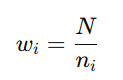

In [7]:
#veure_imatges(train_data,std,mean)

Ara ja tenim el training preparat. El provarem amb el validation a continuació

##ENTRENAMENT

In [8]:
def tria_model(numero_model,weights):
  if numero_model == 0:
    alexnetbinary = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)

    alexnetbinary.classifier = nn.Sequential(
    torch.nn.Linear(9216, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 1024),
    nn.ReLU(),
    torch.nn.Linear(1024, 512),
    nn.ReLU(),
    torch.nn.Linear(512, 1)
    )
    pos_weight = torch.tensor(weights,device = device)
    # print(pos_weight.shape)
    # print(pos_weight)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return alexnetbinary,loss_fn

  # elif numero_model == 1:
  #   resnetbinary = models.resnet50(weights="IMAGENET1K_V1")
  #   resnetbinary.fc = nn.Linear(in_features=2048, out_features=1)

  #   pos_weight = torch.tensor(weights,device = device)
  #   loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  #   return resnetbinary,loss_fn

  elif numero_model == 1:
    resnetbinary = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetbinary.fc.in_features
    resnetbinary.fc = nn.Linear(in_features=num_features, out_features=1)

    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    return resnetbinary,loss_fn

  elif numero_model == 2:
    googlenet = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    googlenet.aux_logits = False

    num_features = googlenet.fc.in_features
    googlenet.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenet,loss_fn

  elif numero_model == 3:
    efficientnet = models.efficientnet_b1(weights='IMAGENET1K_V1')
    pos_weight = torch.tensor(weights,device = device)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    num_features = efficientnet.classifier[1].in_features
    efficientnet.classifier[1] = nn.Linear(in_features=num_features, out_features=1)

    return efficientnet,loss_fn

  elif numero_model == 4:

    alexnetmulticlass = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
    alexnetmulticlass.classifier[6] = nn.Linear(in_features=4096, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return alexnetmulticlass,loss_fn

  # elif numero_model == 6:

  #   resnetmulticlass = models.resnet50(weights="IMAGENET1K_V1")
  #   num_features = resnetmulticlass.fc.in_features
  #   resnetmulticlass.fc = nn.Linear(in_features=num_features, out_features=7)

  #   weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
  #   loss_fn = nn.CrossEntropyLoss(weight=weights)

  #   return resnetmulticlass,loss_fn

  elif numero_model == 5:
    resnetmulticlass152 = models.resnet152(weights="IMAGENET1K_V1")
    num_features = resnetmulticlass152.fc.in_features
    resnetmulticlass152.fc = nn.Linear(in_features=num_features, out_features=7)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    return resnetmulticlass152,loss_fn

  elif numero_model == 6:

    googlenetmulticlass = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = googlenetmulticlass.fc.in_features
    googlenetmulticlass.fc = nn.Linear(in_features=num_features, out_features=1)

    return googlenetmulticlass,loss_fn

  elif numero_model == 7:

    efficientnetmulticlass = models.efficientnet_b1(weights='IMAGENET1K_V1')

    weights = torch.tensor(weights,device = device,dtype= torch.float32).squeeze(0)
    loss_fn = nn.CrossEntropyLoss(weight=weights)

    num_features = efficientnetmulticlass.classifier[1].in_features
    efficientnetmulticlass.classifier[1] = nn.Linear(in_features=num_features, out_features=7)

    return efficientnetmulticlass,loss_fn



In [9]:
def converteix_a_binari(target):
  #{'nv': 0, 'mel': 1, 'bkl': 2, 'bcc': 3, 'akiec': 4, 'vasc': 5, 'df': 6}
  diseases = {'0': 0,'1':1,'2': 0,'3': 1,'4':1,'5':0,'6':0}
  target = ([[str(num.item())] for num in target])

  mapped_tensor = torch.tensor([[diseases[num[0]]] for num in target])
  return mapped_tensor

In [10]:
def train(model,loss_fn,dataloader,optimizer,epoch,device):

  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0
  train_loss = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):
        model.train()
        optimizer.zero_grad()

        input_img = input_img.to(device)
        output = model(input_img.to(device))

        #print(output.shape[1])

        if output.shape[1] > 1: #multiclass
          a = 1
        else: #binary
          target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
          target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

        if output.shape[1] > 1:
          target = target.to(device)
          loss = loss_fn(output, target)
        else:
          target = target.to(device)
          loss = loss_fn(output, target.float())


        if output.shape[1] > 1:
          output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
          output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
          output = output.cpu().detach().numpy()
        else:
          output = torch.sigmoid(output)   #funció sigmoide per al cas binari
          output = (output.cpu().detach().numpy() > 0.5).astype(int)

        target = target.cpu().detach().numpy()

        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        train_acc += accuracy_score(target,output)
        train_f1 += f1_score(target,output,average='weighted',zero_division=1)
        train_recall += recall_score(target,output,average='weighted',zero_division=1)
        train_precision += precision_score(target,output,average='weighted',zero_division=1)
        train_loss += loss.item()

  return train_acc,train_f1,train_recall,train_precision,train_loss


In [11]:
def validate(model,loss_fn,data_loader,device):
  val_acc = 0
  val_f1 = 0
  val_recall = 0
  val_precision = 0
  val_loss = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):

            input_img = input_img.to(device)
            output = model(input_img)


            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits
              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari
              output = (output.cpu().detach().numpy() > 0.5).astype(int)


            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,output)
            val_f1 += f1_score(target,output,average='weighted',zero_division=1)
            val_recall += recall_score(target,output,average='weighted',zero_division=1)
            val_precision += precision_score(target,output,average='weighted',zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [12]:
from ast import And
def execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,epochs,device):

  t_loss = np.zeros(epochs)
  v_loss = np.zeros(epochs)
  acc_t = np.zeros(epochs)
  acc_v = np.zeros(epochs)
  f1_t = np.zeros(epochs)
  f1_v = np.zeros(epochs)
  recall_t = np.zeros(epochs)
  recall_v = np.zeros(epochs)


  interval = 5
  requerit = 0.010
  last_loss = float('inf')

  epoch_number = 0

  pbar = tqdm(range(1, epochs + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:

      train_loss = 0
      train_acc = 0
      train_precision = 0
      train_f1 = 0
      train_recall = 0
      val_acc = 0
      val_recall = 0
      val_f1 = 0
      val_loss = 0
      val_precision = 0

      batch_num = 1

      train_acc,train_f1,train_recall,train_precision,train_loss = train(model,loss_fn,train_loader,optimizer,epoch,device)
      val_acc,val_f1,val_recall,val_precision,val_loss  = validate(model,loss_fn,val_loader,device)

      if WEIGHTSANDBIASES:

        training_metrics = {"train/train_loss": train_loss/len(train_loader),
                        "train/train_acc":train_acc/len(train_loader),
                        "train/train_f1":train_f1/len(train_loader),
                        "train/train_recall":train_recall/len(train_loader),
                        "train/train_precision":train_precision/len(train_loader)}

        val_metrics = {"val/val_loss": val_loss/len(val_loader),
                      "val/val_acc":val_acc/len(val_loader),
                      "val/val_f1":val_f1/len(val_loader),
                      "val/val_recall": val_recall/len(val_loader),
                      "val/val_precision": val_precision/len(val_loader)}

        wandb.log({**training_metrics, **val_metrics})

      # RESULTATS
      train_loss /= len(train_loader)
      train_acc /= len(train_loader)
      train_f1 /= len(train_loader)
      train_recall /= len(train_loader)
      train_precision /= len(train_loader)

      print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
      print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
      print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
      print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")

      val_loss /= len(val_loader)
      val_acc /= len(val_loader)
      val_f1 /= len(val_loader)
      val_recall /= len(val_loader)
      val_precision /= len(val_loader)

      print()
      print()
      print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
      print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
      print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
      print(f"Recall val epoch: {epoch}  val_recall: {val_recall}")
      print(f"Recall val epoch: {epoch}  val_precision: {val_precision}")



      if interval > 0:
        interval -= 1

      if interval == 0:
        if last_loss - requerit < train_loss:
            print("Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!")
            break
        else:
          interval = 5
          last_loss = train_loss

  return model

In [13]:
def test(model,dataloader,weights_dir,loss_fn,device):

  model.load_state_dict(torch.load(weights_dir))

  test_acc = 0
  test_f1 = 0
  test_recall = 0
  test_precision = 0
  test_loss = 0

  json_obj = []

  model.eval()

  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(dataloader):

            input_img = input_img.to(device)
            output = model(input_img)

            dades = {}

            if output.shape[1] > 1: #multiclass
              a = 1
            else: #binary
              target = torch.unsqueeze(target, 1) #separa [1,2,3,4] en [[1],[2],[3]]
              target = converteix_a_binari(target) #només si volem saber si la enfermetat es benigna o no

            if output.shape[1] > 1:
              target = target.to(device)
              loss = loss_fn(output, target)
            else:
              target = target.to(device)
              loss = loss_fn(output, target.float())


            if output.shape[1] > 1:
              output = torch.softmax(output,dim = 1) #calculam les probabilitats de cada classe a partir dels logits

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = output.argmax(dim=1) #obtenim la classe que té la probabilitat més alta de les 7
              output = output.cpu().detach().numpy()
            else:
              output = torch.sigmoid(output)   #funció sigmoide per al cas binari

              dades["output"] = output.cpu().detach().tolist() #guardam les probabilitats de l'output

              output = (output.cpu().detach().numpy() > 0.5).astype(int)

            dades["target"] = target.cpu().detach().tolist()

            target = target.cpu().detach().numpy()

            dades["top1-accuracy"] = accuracy_score(target,output)
            test_acc  += dades["top1-accuracy"]
            dades["f1-score"] = f1_score(target,output,average='weighted',zero_division=1)
            test_f1 += dades["f1-score"]
            dades["recall"] = recall_score(target,output,average='weighted',zero_division=1)
            test_recall += dades["recall"]
            dades["precision"] = precision_score(target,output,average='weighted',zero_division=1)
            test_precision += dades["precision"]

            dades["loss"] = loss.item()
            test_loss += dades["loss"]

            json_obj.append(dades)


  return json_obj

In [14]:
def veure_imatges(train_data):
  for i in range(len(train_data)):
    path = train_data.__getpath__(i)
    clean_img = cv2.imread(path)
    mean, std = cv2.meanStdDev(clean_img)

    clean_img = cv2.resize(clean_img, (224, 224))
    clean_img = torch.tensor(clean_img).permute(2, 0, 1)  # Convert to (C, H, W)

    print(clean_img.shape)

    imatge,label = train_data.__getitem__(i)
    print(imatge.shape)
    std = std.flatten()
    mean = mean.flatten()
    imatge = imatge * (std[:, None, None]) + (mean[:, None, None])

    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    clean_img = clean_img.permute(1, 2, 0).numpy() #clean_img no es un torch

    combined_image = np.concatenate((img_numpy, clean_img), axis=1)
    cv2_imshow(combined_image)

    time.sleep(5)
    clear_output(wait=True)

In [15]:
from itertools import product
BINARY = True #Si volem que el resultat de la classificació sigui 0 i 1

architectures = {'alexnet': 0,'resnet152':1,'inceptionv3':2,'efficientnetb1':3,'alexnetmulticlass':4,'resnet152multiclass':5,'inceptionv3multiclass':6,'efficientnetb1multiclass':7}
nom_model = 'resnet152multiclass'
MODEL = architectures[nom_model]

TRAINING = 0.80
VALIDATION = 0.10
TESTING = 0.10
SIZE = 224


mean = torch.tensor([194.57463374, 139.13953272, 145.36132088]) /255 #rgb
std = torch.tensor([35.92275236, 38.90347617, 43.33101831]) / 255

TRANSFORMATIONS = []
DISTRIBUTIONS = None


transform = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std)
])

transform_training = transforms.Compose([
    transforms.Resize((SIZE,SIZE)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean, std=std),
])

CLAHE = False
train_data,validation_data,test_data = load_sets(transform_training,transform,TRAINING,VALIDATION,TESTING,DISTRIBUTIONS)


EPOCHS = 50
batch_size = 32

binary_weights, multiple_weights = get_weights()

if MODEL < 4:
  weights = binary_weights
else:
  weights = multiple_weights

print(weights)
learning_rate  = 1e-5


train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

model,loss_fn = tria_model(MODEL,weights)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.to(device)

projectes = ['Ham10000-AlexnetBinary','Ham1000-Resnet152Binary','Ham10000-Inceptionv3Binary','Ham10000-EfficientNetB1Binary',
              'Ham10000-AlexnetMulticlass','Ham10000Resnet152Multiclass','Ham10000-Inceptionv3Multiclass','Ham10000-EfficientNetB1Multiclass']

parametres_training = {
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "testsize":len(test_loader),
                "testdist": TESTING,
                "loss_weights":str(weights),
                "CLAHE": CLAHE,
                "data_augmentation": str(transform_training)
}

carpeta_drive = '/content/drive/MyDrive/Runs/' + projectes[MODEL]
os.makedirs(carpeta_drive, exist_ok=True) #cream la carpeta si no existeix

current_runs = len([d for d in os.listdir(carpeta_drive) if os.path.isdir(os.path.join(carpeta_drive, d))]) #número d'execucions fetes de cada model

#cada execució tindrà la seva carpeta numerada

json_object = json.dumps(parametres_training,indent = 2)

#cream la carpeta de l'execució

num_execucio = str(current_runs)
carpeta_execucio = carpeta_drive+"/"+ num_execucio
os.makedirs(carpeta_execucio,exist_ok=True)

#afegim la informació d'entrenament a la carpeta
with open(carpeta_execucio+"/training_info.json", "w") as outfile:
  outfile.write(json_object)


if WEIGHTSANDBIASES:
    wandb.init(
            project=projectes[MODEL],
            config={
                "epochs": EPOCHS,
                "batch_size": batch_size,
                "lr": learning_rate,
                "trsize":len(train_loader),
                "trdist":TRAINING,
                "vsize":len(val_loader),
                "vdist":VALIDATION,
                "weights":weights,
                "CLAHE": CLAHE,
                })
    config = wandb.config
    print(config)

#guardam els pesos a la carpeta de drive
best_model = execute(model,loss_fn,train_loader,val_loader,test_loader,optimizer,EPOCHS,device)
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+num_execucio+'.pt'
torch.save(model.state_dict(), carpeta_pesos )

#també guardam els resultats del test a la carpeta de drive
carpeta_pesos = carpeta_execucio+'/pesos_'+nom_model+'_'+str(current_runs)+'.pt'

resultats = test(model,test_loader,carpeta_pesos,loss_fn,device)

with open(carpeta_execucio+"/testing_info.json", "w") as outfile:
    json.dump(resultats, outfile, indent=3)


wandb.finish()

[0.00657042 0.03958192 0.04008614 0.08570948 0.13472377 0.31024417
 0.3830841 ]


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 167MB/s]


{'epochs': 50, 'batch_size': 32, 'lr': 1e-05, 'trsize': 251, 'trdist': 0.8, 'vsize': 32, 'vdist': 0.1, 'weights': [0.0065704208816761995, 0.03958191555403316, 0.04008614377765142, 0.08570947862186559, 0.13472376761969088, 0.31024416909604874, 0.383084104449034], 'CLAHE': False}


  0%|          | 0/50 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 1  train_loss: 1.3313168841766647
Accuracy train epoch: 1  train_acc: 0.47775941687794277
F1 train epoch: 1  train_f1: 0.5200301611620332
Recall train epoch: 1  train_recall: 0.47775941687794277


Pèrdua validació epoch: 1  val_loss: 0.8855626946315169
Accuracy val epoch: 1  val_acc: 0.6974609375
F1 val epoch: 1  val_f1: 0.7393587097948274
Recall val epoch: 1  val_recall: 0.6974609375
Recall val epoch: 1  val_precision: 0.8367849351233425


Batches (Època 2): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 2  train_loss: 0.7802902948096454
Accuracy train epoch: 2  train_acc: 0.7048284136182542
F1 train epoch: 2  train_f1: 0.7488407656180963
Recall train epoch: 2  train_recall: 0.7048284136182542


Pèrdua validació epoch: 2  val_loss: 0.6793607408180833
Accuracy val epoch: 2  val_acc: 0.7517578125
F1 val epoch: 2  val_f1: 0.7823894098697594
Recall val epoch: 2  val_recall: 0.7517578125
Recall val epoch: 2  val_precision: 0.8531767705326878


Batches (Època 3): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 3  train_loss: 0.622776771387256
Accuracy train epoch: 3  train_acc: 0.7536445128576602
F1 train epoch: 3  train_f1: 0.7899451661680733
Recall train epoch: 3  train_recall: 0.7536445128576602


Pèrdua validació epoch: 3  val_loss: 0.5808451739139855
Accuracy val epoch: 3  val_acc: 0.791015625
F1 val epoch: 3  val_f1: 0.8141189796519784
Recall val epoch: 3  val_recall: 0.791015625
Recall val epoch: 3  val_precision: 0.8764613113837001


Batches (Època 4): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 4  train_loss: 0.5006152660367024
Accuracy train epoch: 4  train_acc: 0.783151484969214
F1 train epoch: 4  train_f1: 0.8137155857736047
Recall train epoch: 4  train_recall: 0.783151484969214


Pèrdua validació epoch: 4  val_loss: 0.5461398039478809
Accuracy val epoch: 4  val_acc: 0.78359375
F1 val epoch: 4  val_f1: 0.8057226405129887
Recall val epoch: 4  val_recall: 0.78359375
Recall val epoch: 4  val_precision: 0.8627606492033617


Batches (Època 5): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 5  train_loss: 0.4089488370781876
Accuracy train epoch: 5  train_acc: 0.8051996559217675
F1 train epoch: 5  train_f1: 0.8317426423397473
Recall train epoch: 5  train_recall: 0.8051996559217675


Pèrdua validació epoch: 5  val_loss: 0.5340093732811511
Accuracy val epoch: 5  val_acc: 0.823828125
F1 val epoch: 5  val_f1: 0.8376274570197995
Recall val epoch: 5  val_recall: 0.823828125
Recall val epoch: 5  val_precision: 0.8874094843951413


Batches (Època 6): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 6  train_loss: 0.3819187484176985
Accuracy train epoch: 6  train_acc: 0.8215999637812387
F1 train epoch: 6  train_f1: 0.8461156507191587
Recall train epoch: 6  train_recall: 0.8215999637812387


Pèrdua validació epoch: 6  val_loss: 0.4953363314270973
Accuracy val epoch: 6  val_acc: 0.8271484375
F1 val epoch: 6  val_f1: 0.8397468795078111
Recall val epoch: 6  val_recall: 0.8271484375
Recall val epoch: 6  val_precision: 0.8903695230584258


Batches (Època 7): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 7  train_loss: 0.3131435756604985
Accuracy train epoch: 7  train_acc: 0.8435236327417602
F1 train epoch: 7  train_f1: 0.8664669305884009
Recall train epoch: 7  train_recall: 0.8435236327417602


Pèrdua validació epoch: 7  val_loss: 0.46627866197377443
Accuracy val epoch: 7  val_acc: 0.8490234375
F1 val epoch: 7  val_f1: 0.8601475237147047
Recall val epoch: 7  val_recall: 0.8490234375
Recall val epoch: 7  val_precision: 0.8906078610165368


Batches (Època 8): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 8  train_loss: 0.2804479488724494
Accuracy train epoch: 8  train_acc: 0.8598333936979355
F1 train epoch: 8  train_f1: 0.8785440750092213
Recall train epoch: 8  train_recall: 0.8598333936979355


Pèrdua validació epoch: 8  val_loss: 0.47096719057299197
Accuracy val epoch: 8  val_acc: 0.8328125
F1 val epoch: 8  val_f1: 0.8460338467462722
Recall val epoch: 8  val_recall: 0.8328125
Recall val epoch: 8  val_precision: 0.890573149583209


Batches (Època 9): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 9  train_loss: 0.24300403394309647
Accuracy train epoch: 9  train_acc: 0.8697822346975733
F1 train epoch: 9  train_f1: 0.8884320770380741
Recall train epoch: 9  train_recall: 0.8697822346975733


Pèrdua validació epoch: 9  val_loss: 0.4815392862074077
Accuracy val epoch: 9  val_acc: 0.8560546875
F1 val epoch: 9  val_f1: 0.8632385328859966
Recall val epoch: 9  val_recall: 0.8560546875
Recall val epoch: 9  val_precision: 0.9034050149092006


Batches (Època 10): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 10  train_loss: 0.20911324482811874
Accuracy train epoch: 10  train_acc: 0.8929396052155016
F1 train epoch: 10  train_f1: 0.9080265415287824
Recall train epoch: 10  train_recall: 0.8929396052155016


Pèrdua validació epoch: 10  val_loss: 0.4592464391607791
Accuracy val epoch: 10  val_acc: 0.8671875
F1 val epoch: 10  val_f1: 0.878074539569669
Recall val epoch: 10  val_recall: 0.8671875
Recall val epoch: 10  val_precision: 0.9133514910355045


Batches (Època 11): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 11  train_loss: 0.18993263037140626
Accuracy train epoch: 11  train_acc: 0.8996513944223108
F1 train epoch: 11  train_f1: 0.9125472345262501
Recall train epoch: 11  train_recall: 0.8996513944223108


Pèrdua validació epoch: 11  val_loss: 0.41603120998479426
Accuracy val epoch: 11  val_acc: 0.8708984375
F1 val epoch: 11  val_f1: 0.8794931663412261
Recall val epoch: 11  val_recall: 0.8708984375
Recall val epoch: 11  val_precision: 0.9048906714477143


Batches (Època 12): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 12  train_loss: 0.1743330070118149
Accuracy train epoch: 12  train_acc: 0.9054011227816009
F1 train epoch: 12  train_f1: 0.9188088686958588
Recall train epoch: 12  train_recall: 0.9054011227816009


Pèrdua validació epoch: 12  val_loss: 0.4585923149716109
Accuracy val epoch: 12  val_acc: 0.8767578125
F1 val epoch: 12  val_f1: 0.8819938322498116
Recall val epoch: 12  val_recall: 0.8767578125
Recall val epoch: 12  val_precision: 0.9145986581788178


Batches (Època 13): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 13  train_loss: 0.16283628723743665
Accuracy train epoch: 13  train_acc: 0.9130070626584571
F1 train epoch: 13  train_f1: 0.9250848311520653
Recall train epoch: 13  train_recall: 0.9130070626584571


Pèrdua validació epoch: 13  val_loss: 0.52022096933797
Accuracy val epoch: 13  val_acc: 0.8845703125
F1 val epoch: 13  val_f1: 0.8907735998721146
Recall val epoch: 13  val_recall: 0.8845703125
Recall val epoch: 13  val_precision: 0.9214004872782445


Batches (Època 14): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 14  train_loss: 0.15943525589824437
Accuracy train epoch: 14  train_acc: 0.9161082940963419
F1 train epoch: 14  train_f1: 0.9284988089114324
Recall train epoch: 14  train_recall: 0.9161082940963419


Pèrdua validació epoch: 14  val_loss: 0.5012876070104539
Accuracy val epoch: 14  val_acc: 0.87265625
F1 val epoch: 14  val_f1: 0.8830366841797133
Recall val epoch: 14  val_recall: 0.87265625
Recall val epoch: 14  val_precision: 0.9185621858169336


Batches (Època 15): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 15  train_loss: 0.11591226704032773
Accuracy train epoch: 15  train_acc: 0.9322822346975733
F1 train epoch: 15  train_f1: 0.9420315219886279
Recall train epoch: 15  train_recall: 0.9322822346975733


Pèrdua validació epoch: 15  val_loss: 0.48196146258851513
Accuracy val epoch: 15  val_acc: 0.884375
F1 val epoch: 15  val_f1: 0.8909623421080419
Recall val epoch: 15  val_recall: 0.884375
Recall val epoch: 15  val_precision: 0.9220430200852694


Batches (Època 16): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 16  train_loss: 0.11559940473477086
Accuracy train epoch: 16  train_acc: 0.9379980079681275
F1 train epoch: 16  train_f1: 0.9468821661733413
Recall train epoch: 16  train_recall: 0.9379980079681275


Pèrdua validació epoch: 16  val_loss: 0.518877423251979
Accuracy val epoch: 16  val_acc: 0.8873046875
F1 val epoch: 16  val_f1: 0.8914677250994038
Recall val epoch: 16  val_recall: 0.8873046875
Recall val epoch: 16  val_precision: 0.9217599415110592


Batches (Època 17): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 17  train_loss: 0.10455690652310136
Accuracy train epoch: 17  train_acc: 0.9458529518290474
F1 train epoch: 17  train_f1: 0.954127225064377
Recall train epoch: 17  train_recall: 0.9458529518290474


Pèrdua validació epoch: 17  val_loss: 0.5457241880940273
Accuracy val epoch: 17  val_acc: 0.8984375
F1 val epoch: 17  val_f1: 0.9063047691396767
Recall val epoch: 17  val_recall: 0.8984375
Recall val epoch: 17  val_precision: 0.9336803025317689


Batches (Època 18): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 18  train_loss: 0.1030687724436778
Accuracy train epoch: 18  train_acc: 0.9421065737051793
F1 train epoch: 18  train_f1: 0.9508213328477344
Recall train epoch: 18  train_recall: 0.9421065737051793


Pèrdua validació epoch: 18  val_loss: 0.5434890392352827
Accuracy val epoch: 18  val_acc: 0.8951171875
F1 val epoch: 18  val_f1: 0.8986746748381588
Recall val epoch: 18  val_recall: 0.8951171875
Recall val epoch: 18  val_precision: 0.9257295950755019


Batches (Època 19): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 19  train_loss: 0.10863429812558618
Accuracy train epoch: 19  train_acc: 0.9427290836653387
F1 train epoch: 19  train_f1: 0.9521652411834127
Recall train epoch: 19  train_recall: 0.9427290836653387


Pèrdua validació epoch: 19  val_loss: 0.5208153006387874
Accuracy val epoch: 19  val_acc: 0.904296875
F1 val epoch: 19  val_f1: 0.9093641690882197
Recall val epoch: 19  val_recall: 0.904296875
Recall val epoch: 19  val_precision: 0.9320049497469897


Batches (Època 20): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 20  train_loss: 0.08767207000642065
Accuracy train epoch: 20  train_acc: 0.9534475733429917
F1 train epoch: 20  train_f1: 0.9597391893513251
Recall train epoch: 20  train_recall: 0.9534475733429917


Pèrdua validació epoch: 20  val_loss: 0.49250293313525617
Accuracy val epoch: 20  val_acc: 0.8865234375
F1 val epoch: 20  val_f1: 0.8946994733897299
Recall val epoch: 20  val_recall: 0.8865234375
Recall val epoch: 20  val_precision: 0.924508126950539


Batches (Època 21): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 21  train_loss: 0.08408874238793
Accuracy train epoch: 21  train_acc: 0.9512065374864179
F1 train epoch: 21  train_f1: 0.9579771561045186
Recall train epoch: 21  train_recall: 0.9512065374864179


Pèrdua validació epoch: 21  val_loss: 0.4784976941300556
Accuracy val epoch: 21  val_acc: 0.9099609375
F1 val epoch: 21  val_f1: 0.9106599242593041
Recall val epoch: 21  val_recall: 0.9099609375
Recall val epoch: 21  val_precision: 0.9316233481644176


Batches (Època 22): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 22  train_loss: 0.10348200908791556
Accuracy train epoch: 22  train_acc: 0.9532098877218399
F1 train epoch: 22  train_f1: 0.9610193827667681
Recall train epoch: 22  train_recall: 0.9532098877218399


Pèrdua validació epoch: 22  val_loss: 0.4549438473768532
Accuracy val epoch: 22  val_acc: 0.90234375
F1 val epoch: 22  val_f1: 0.9055660289998899
Recall val epoch: 22  val_recall: 0.90234375
Recall val epoch: 22  val_precision: 0.9262428280971478


Batches (Època 23): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 23  train_loss: 0.09508849691184038
Accuracy train epoch: 23  train_acc: 0.9528137450199203
F1 train epoch: 23  train_f1: 0.9598674472976962
Recall train epoch: 23  train_recall: 0.9528137450199203


Pèrdua validació epoch: 23  val_loss: 0.43585812160745263
Accuracy val epoch: 23  val_acc: 0.892578125
F1 val epoch: 23  val_f1: 0.8960366412638682
Recall val epoch: 23  val_recall: 0.892578125
Recall val epoch: 23  val_precision: 0.9213988778868283


Batches (Època 24): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 24  train_loss: 0.06649072196675962
Accuracy train epoch: 24  train_acc: 0.9601706809127127
F1 train epoch: 24  train_f1: 0.9660914284507408
Recall train epoch: 24  train_recall: 0.9601706809127127


Pèrdua validació epoch: 24  val_loss: 0.4293389703379944
Accuracy val epoch: 24  val_acc: 0.908203125
F1 val epoch: 24  val_f1: 0.9052756362822174
Recall val epoch: 24  val_recall: 0.908203125
Recall val epoch: 24  val_precision: 0.9271458295355564


Batches (Època 25): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 25  train_loss: 0.05573363922187591
Accuracy train epoch: 25  train_acc: 0.9688858203549439
F1 train epoch: 25  train_f1: 0.9734420800268618
Recall train epoch: 25  train_recall: 0.9688858203549439


Pèrdua validació epoch: 25  val_loss: 0.44715479121077806
Accuracy val epoch: 25  val_acc: 0.89609375
F1 val epoch: 25  val_f1: 0.8983267212300321
Recall val epoch: 25  val_recall: 0.89609375
Recall val epoch: 25  val_precision: 0.9326885523929221


Batches (Època 26): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 26  train_loss: 0.05261552758678141
Accuracy train epoch: 26  train_acc: 0.9691461427019196
F1 train epoch: 26  train_f1: 0.9737436333148257
Recall train epoch: 26  train_recall: 0.9691461427019196


Pèrdua validació epoch: 26  val_loss: 0.4513954386347905
Accuracy val epoch: 26  val_acc: 0.905078125
F1 val epoch: 26  val_f1: 0.9062775386528952
Recall val epoch: 26  val_recall: 0.905078125
Recall val epoch: 26  val_precision: 0.9329439903011709


Batches (Època 27): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 27  train_loss: 0.06355733701410106
Accuracy train epoch: 27  train_acc: 0.9650375769648678
F1 train epoch: 27  train_f1: 0.9700063227728543
Recall train epoch: 27  train_recall: 0.9650375769648678


Pèrdua validació epoch: 27  val_loss: 0.47489905322436243
Accuracy val epoch: 27  val_acc: 0.897265625
F1 val epoch: 27  val_f1: 0.8992618893416755
Recall val epoch: 27  val_recall: 0.897265625
Recall val epoch: 27  val_precision: 0.9254673267270924


Batches (Època 28): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 28  train_loss: 0.0750041649012689
Accuracy train epoch: 28  train_acc: 0.9580428286852589
F1 train epoch: 28  train_f1: 0.9639648110164294
Recall train epoch: 28  train_recall: 0.9580428286852589


Pèrdua validació epoch: 28  val_loss: 0.4308370838407427
Accuracy val epoch: 28  val_acc: 0.920703125
F1 val epoch: 28  val_f1: 0.9221418050392622
Recall val epoch: 28  val_recall: 0.920703125
Recall val epoch: 28  val_precision: 0.9425554846514964


Batches (Època 29): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 29  train_loss: 0.0681740314796181
Accuracy train epoch: 29  train_acc: 0.9666447844983701
F1 train epoch: 29  train_f1: 0.9717632898476753
Recall train epoch: 29  train_recall: 0.9666447844983701


Pèrdua validació epoch: 29  val_loss: 0.45533356901432853
Accuracy val epoch: 29  val_acc: 0.904296875
F1 val epoch: 29  val_f1: 0.9092365398378792
Recall val epoch: 29  val_recall: 0.904296875
Recall val epoch: 29  val_precision: 0.9391928085399752


Batches (Època 30): 0it [00:00, ?it/s]

Pèrdua entrenament epoch: 30  train_loss: 0.05847947298460065
Accuracy train epoch: 30  train_acc: 0.9713758601955813
F1 train epoch: 30  train_f1: 0.9762261976282794
Recall train epoch: 30  train_recall: 0.9713758601955813


Pèrdua validació epoch: 30  val_loss: 0.43081892508780584
Accuracy val epoch: 30  val_acc: 0.912890625
F1 val epoch: 30  val_f1: 0.9171951782293569
Recall val epoch: 30  val_recall: 0.912890625
Recall val epoch: 30  val_precision: 0.940085682531737
Early Stopping, no hem reduït ni un 0.03 de loss respecte 10 èpoques!!


train/train_acc,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████████████
train/train_f1,▁▅▅▆▆▆▆▇▇▇▇▇▇▇▇███████████████
train/train_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/train_precision,▁▂▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇███████████
train/train_recall,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇███████████████
val/val_acc,▁▃▄▄▅▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇█▇▇█▇█▇█▇█
val/val_f1,▁▃▄▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇█▇█▇▇▇▇▇▇███
val/val_loss,█▅▃▃▃▂▂▂▂▂▁▂▃▂▂▃▃▃▃▂▂▂▁▁▁▂▂▁▂▁
val/val_precision,▁▂▄▃▄▅▅▅▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇███
val/val_recall,▁▃▄▄▅▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇█▇▇█▇█▇█▇█
train/train_acc,0.97138


In [16]:
# print(validation_data.__getmask__(3))
# print(validation_data.__getpath__(3))
# print(validation_data.__len__())
# print(validation_data.__lenmasks__())

In [17]:
#veure_imatges(train_data)